# *PROJET : Prédiction de séries temporelles*

**NOM**    PLUSQUELLEC <br>
**PRÉNOM** *Valérie*

## Introduction

Ce projet porte sur le développement d'un modèle de prévision de la température à partir de données de capteurs environnementaux. Les données proviennent du Jena Climate Dataset, un jeu de mesures réelles collectées sur 4 ans (2016–2020) à 10 minutes d'intervalle. 
L'objectif est de construire un modèle de séries temporelles capable de prédire la température à partir des autres variables, en utilisant un réseau récurrent LSTM implémenté avec TensorFlow. 

## Chargement et présentation du dataset

In [2]:
import pandas as pd

data = pd.read_csv('meteo_dataset.csv')
data

,Pressure,Temperature,Saturation vapor pressure,Vapor pressure deficit,Specific humidity,Airtight,Wind speed
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944
...,...,...,...,...,...,...,...
420546,1.386902,-1.540264,-1.164797,-0.580316,-1.456301,1.876123,-0.968745
420547,1.369887,-1.459199,-1.132237,-0.534520,-1.452583,1.789472,-0.660963
420548,1.356518,-1.437195,-1.123121,-0.511622,-1.460020,1.763770,-0.700254
420549,1.355303,-1.561109,-1.172611,-0.571990,-1.482333,1.890320,-0.431764


Le Jena Climate Dataset contient 420 551 observations chronologiques (10 minutes d'intervalle, 2009-2016) issues de la station météo du Max Planck Institute à Jena, Allemagne. Les données ont été préalablement normalisées (MinMaxScaler) et réduites à 7 features prédictives : la pression, la température, la saturation, le déficit de pression de vapeur, l' humidité, la densité et la vitesse du vent.

Nous pouvons observer les variations de certains de ces paramètres au cours du temps pour l’ensemble du jeu de données, en traçant leur évolution au cours du temps :

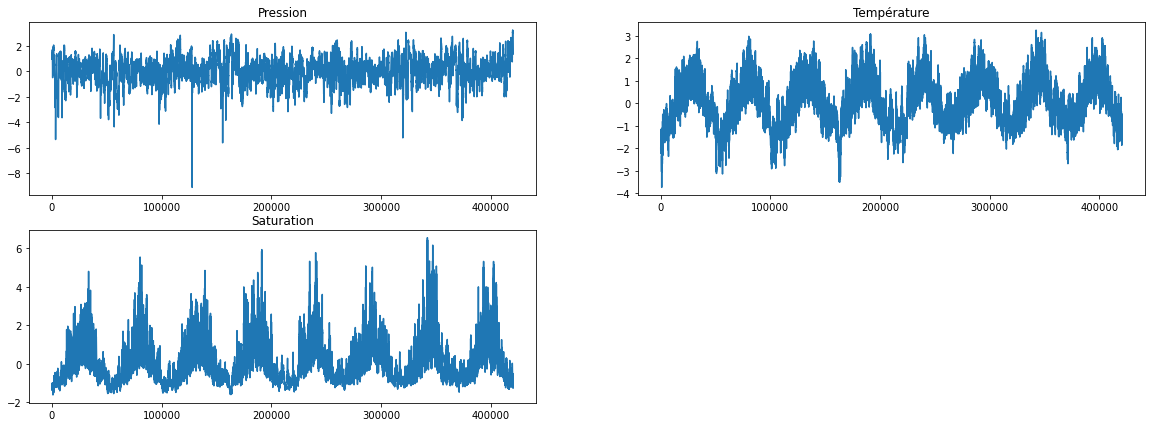

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,7))
# Évolution de la pression
ax1 = fig.add_subplot(221)
plt.plot(data['Pressure'])
ax1.title.set_text('Pression')
# Évolution de la température
ax2 = fig.add_subplot(222)
plt.plot(data['Temperature'])
ax2.title.set_text('Température')
# Évolution de la saturation
ax3 = fig.add_subplot(223)
plt.plot(data['Saturation vapor pressure'])
ax3.title.set_text('Saturation')

plt.show()

Ainsi, la température et la saturation ont des évolutions périodiques très marquées, avec une cohérence temporelle élevée (saisonnnalité annuelle, cycle diurne), et présente un bruit modéré, ce qui est un terrain propice à une prédiction LSTM.
À l’inverse, la courbe de pression présente une forte variabilité sans périodicité claire et avec des outliers fréquents. Ce paramètre risque donc d’être nettement plus difficile à prédire.

## Prédiction de la température à partir des autres variables

Pour éviter le data leakage inhérent aux séries temporelles (les observations ne sont pas Indépendantes et Identiquement Distribuées), une division temporelle stricte a été appliquée :

In [7]:
split_fraction = 0.80
split_idx =int(split_fraction * len(data))

# Train: on conserve les 80% premières lignes
train_data = data.loc[0:split_idx-1].values
# Test: on conserve les 20% dernières lignes
val_data = data.loc[split_idx:].values

print(f"Jeu d'apprentissage : {train_data.shape}, jeu d'évaluation : {val_data.shape}")

Jeu d'apprentissage : (336440, 7), jeu d'évaluation : (84111, 7)


Dans un premier temps, on s'intéresse à la prédiction de la température à partir des six autres paramètres de la série temporelle.
Il s’agit donc d’une configuration *many-to-many*, c’est-à-dire que le modèle décisionnel consiste à prédire une séquence (la température) à partir d’une séquence de variables explicatives
(les autres paramètres).

Afin d’entraîner le réseau de neurones par descente de gradient, on subdivise le jeu de données en *batch*. 
On se fixera des batchs de taille 256. Pour réduire le temps de calcul, on sous-échantillonnera les données avec un facteur 6 (6 x 10 min = 1h) et on choisira des séquences de longueur 120 éléments (laps de temps de 120h = 5 jours).

In [8]:
import tensorflow as tf

sampling_rate = 6 # Fréquence d'échantillonnage
sequence_length = 120  # Longueur de la séquence
batch_size = 256 # Taille de batch

# Création du jeu d'entraînement

X_train = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data[:, (0,2,3,4,5,6)],
    targets=None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

y_train = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data[:, 1],
    targets=None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)


dataset_train = tf.data.Dataset.zip((X_train, y_train))

# Création du jeu d'évaluation

X_val = tf.keras.utils.timeseries_dataset_from_array(
    data=val_data[:, (0,2,3,4,5,6)],
    targets=None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

y_val = tf.keras.utils.timeseries_dataset_from_array(
    data=val_data[:, 1],
    targets=None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

dataset_val = tf.data.Dataset.zip((X_val, y_val))



2026-02-05 13:14:59.851052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-05 13:15:06.113936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Maintenant que le jeu de données est mis en forme, on peut définir le réseau récurrent utilisé pour prédire la température à partir des autres paramètres météorologiques. On choisit d'implémenter un réseau récurrent simple constitué d’une *Gated Recurrent Unit* (GRU) et de deux couches linéaires.

In [9]:
from tensorflow import keras

In [10]:
dimension = train_data.shape[1]-1
inputs = keras.layers.Input(shape=(sequence_length, dimension))
gru_out = keras.layers.GRU(dimension, return_sequences=True)(inputs)
dense_out = keras.layers.Dense(dimension, activation='relu')(gru_out)
outputs = keras.layers.Dense(1)(dense_out)

model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
learning_rate = 0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 6)]          0         
                                                                 
 gru (GRU)                   (None, 120, 6)            252       
                                                                 
 dense (Dense)               (None, 120, 6)            42        
                                                                 
 dense_1 (Dense)             (None, 120, 1)            7         
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [12]:
epochs = 5

model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
)

Epoch 1/5
1312/1312 [==============================] - 65s 48ms/step - loss: 0.1380 - val_loss: 0.0193
Epoch 2/5
1312/1312 [==============================] - 62s 47ms/step - loss: 0.0167 - val_loss: 0.0070
Epoch 3/5
1312/1312 [==============================] - 63s 48ms/step - loss: 0.0068 - val_loss: 0.0031
Epoch 4/5
1312/1312 [==============================] - 64s 49ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 5/5
1312/1312 [==============================] - 65s 49ms/step - loss: 0.0016 - val_loss: 9.5848e-04


Keras affiche lors de l’apprentissage les scores de validation, ce qui permet de vérifier qu'on n'est pas en régime de sur-apprentissage. Pour une analyse plus qualitative, on peut
visualiser à présent les résultats des prédictions sur les 5 premiers éléments du jeu de validation. 

In [13]:
def show_plot(predicted_data, true_data, title=None):
    plt.title(title)
    plt.plot(predicted_data, "rx", label="Température prédite")
    plt.plot(true_data, ".-", label="Vraie température")
    plt.legend()
    plt.xlabel("Pas de temps")
    plt.show()
    return

8/8 [==============================] - 0s 13ms/step


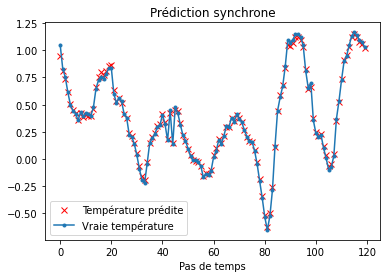

8/8 [==============================] - 0s 13ms/step


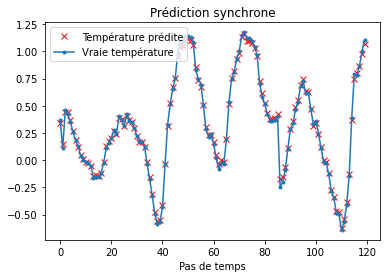

8/8 [==============================] - 0s 13ms/step


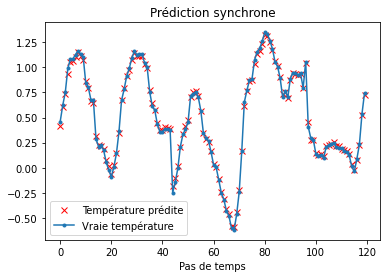

In [15]:
for x, y in dataset_val.take(3):
    show_plot(y[0].numpy(), model.predict(x)[0], title="Prédiction synchrone")

Les prédictions de température sont donc très proches de la vérité terrain. Les performances en train et en test sont bonnes et à peu près équivalentes, ce qui signifie a priori qu’il n’y a pas de surapprentrissage.

Ce modèle récurrent semble à même de prédire avec une haute précision la température à partir des autres paramètres météorologiques, et permet d'imputer des données en cas de données manquantes.

## Prédiction de la température future

On va à présent chercher non plus à reconstruire la température à partir des autres paramètres, mais à prédire la température *future*, c’est-à-dire à $ t+1 $, à partir de toutes les variables météorologiques jusqu’au temps $ t $.

Comme le but est de prédire la température future, on divisera les données en séquences de $ M $ éléments. Chacune aura pour étiquette associée la température $ T $ instants plus tard. Il s’agit donc désormais d’un problème *many-to-one*.

On propose une séquence de $ M = 720 $ observations passées pouir prédire la température à $ T = 6 $ instants plus tard. Les séquences d’entrée démarreront donc à l’indice $ 0 $ tandis que la première étiquette correspondra à l’indice $ 720+6=726 $. Ici encore, la séquence d’origine sera spus-échantillonée par un facteur $ 6 $, ce qui donnera en entrée des séquences de longueur $ 720/6=120 $, comme précédemment. Avec ce sous-échantillonnage, cela revient donc à faire la prédiction $ t+1 $ à partir des $ 120 $ valeurs précédentes.

In [16]:
past_length = 720
future_step = 6

label_start = past_length + future_step  # Début de la séquence des labels
label_end = label_start + split_idx  # Fin de la séquence des labels

x_train = train_data
y_train = data[label_start:label_end][['Temperature']]

x_end = len(val_data) - past_length - future_step # Fin de la séquence des données d'entrées en validation

label_start = split_idx + past_length + future_step # Début de la séquence des labels en validation
x_val = val_data[:x_end]
y_val = data[label_start:][['Temperature']]

In [17]:
batch_size = 256
step_size = 6 # Facteur d'échantillonnage
sequence_length = int(past_length / step_size)

dataset_train = tf.keras.utils.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step_size,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step_size,
    batch_size=batch_size,
)

In [20]:
learning_rate = 0.001

input_dim = train_data.shape[1]
hidden_dim = 32
inputs = keras.layers.Input(shape=(sequence_length, input_dim))
gru_out = keras.layers.GRU(hidden_dim)(inputs)
dense_out = keras.layers.Dense(hidden_dim, activation='relu')(gru_out)
outputs = keras.layers.Dense(1)(dense_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 gru_1 (GRU)                 (None, 32)                3936      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [21]:
epochs = 5

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
)

Epoch 1/5
1312/1312 [==============================] - 113s 85ms/step - loss: 0.0732 - val_loss: 0.0574
Epoch 2/5
1312/1312 [==============================] - 111s 84ms/step - loss: 0.0289 - val_loss: 0.0478
Epoch 3/5
1312/1312 [==============================] - 111s 85ms/step - loss: 0.0254 - val_loss: 0.0399
Epoch 4/5
1312/1312 [==============================] - 111s 85ms/step - loss: 0.0227 - val_loss: 0.0298
Epoch 5/5
1312/1312 [==============================] - 111s 84ms/step - loss: 0.0206 - val_loss: 0.0233


On peut désormais visualiser les résultats en prédiction du modèle sur les trois premières séquences du jeu de
validation :

In [22]:
def show_plot(sequence, prediction, ground_truth, delta=future_step/step_size, title=None):
    plt.title(title)
    plt.plot(sequence.flatten(), ".-", label="Température passée")
    plt.plot(len(sequence) + delta, prediction, "go", label="Prédiction")
    plt.plot(len(sequence) + delta, ground_truth, "rx", label="Vraie température")
    plt.legend()
    plt.xlim(-1, len(sequence) + delta + 3)
    plt.xlabel("Pas de temps")
    plt.show()

8/8 [==============================] - 0s 13ms/step


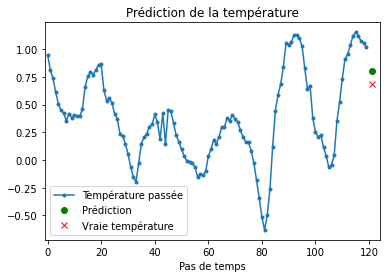

8/8 [==============================] - 0s 15ms/step


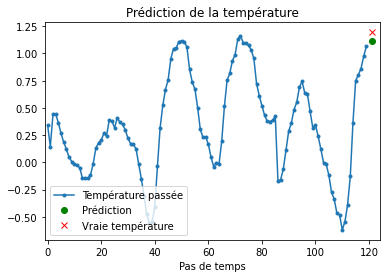

8/8 [==============================] - 0s 13ms/step


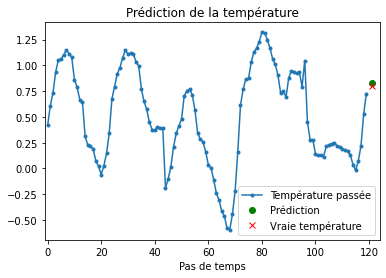

8/8 [==============================] - 0s 13ms/step


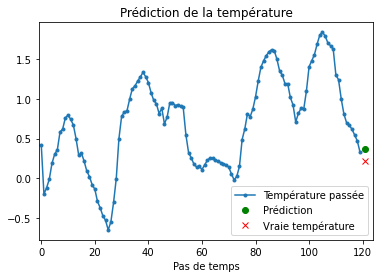

8/8 [==============================] - 0s 13ms/step


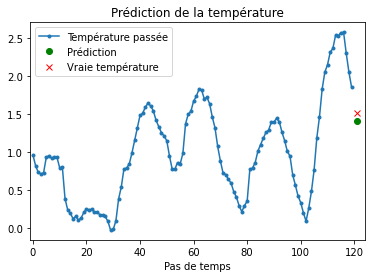

In [23]:
for x, y in dataset_val.take(5):
    show_plot(x[0][:, 1].numpy(), model.predict(x)[0], y[0].numpy(), title="Prédiction de la température")

Les prédictions sont moins précises que précédemment. Il y a plus de grandes erreurs de prédictions entre la température prédite et la température future réelle. Ce n’est pas inattendu car l’on pouvait s’attendre à ce que la prédiction des valeurs futures soit un problème plus difficile que la reconstruction de la température à un pas de temps donné en connaissant toutes les autres variables.

## Synthèse des résultats:

| Scénario  | Architecture      | Input Shape         | RMSE Val (°C)  | Params |
| --------- | ----------------  | ------------------- | -------------- | ------ |
| Synchrone | GRU many-to-many  | (120, 6) → (120, 1) | 0.0360         | 301    |
| Futur 1h  | GRU many-to-one   | (120, 7) → 1        | 0.1526         | 5 025  |